# Data upload

In [1]:
import tarfile
import pandas as pd
import numpy as np
import re
import os
import gzip

directory = os.getcwd()
data_path = os.path.join(directory, 'Data')

# Definining the path for the files
RB_path = os.path.join(data_path, 'RateBeer')
BA_path = os.path.join(data_path, 'BeerAdvocate')
MB_path = os.path.join(data_path, 'matched_beer_data')

# Extraction of the data and preprocessing of the files

In [ ]:
# List the .tar files in the source directory and extract them in the corresponding subfolder
tar_files = [file for file in os.listdir(data_path) if file.endswith('.gz')]

for tar_file in tar_files:
    tar_file_path = os.path.join(data_path, tar_file)

    extraction_folder_name = os.path.basename(tar_file_path).split('.', 1)[0]
    folder_path = os.path.join(data_path, extraction_folder_name)
    os.makedirs(folder_path, exist_ok=True)

    with tarfile.open(tar_file_path, 'r') as tar:
        tar.extractall(path=folder_path)

In [2]:
def text_to_csv(path, filename):
    '''
        This function takes as input the path where the .txt file is located as well as the filename and will create a .tsv file 
        in the same folder from the data in the .txt file. 
        
        The .txt file is read line by line and a dictionary is created to which the different values for each key are appended as 
        the file is read. The "nan" are replaced by empty space ('') to be better recognized when creating a dataframe.
    '''
    main_path = os.path.join(path, filename)
    if not os.path.exists(main_path + '.tsv'):
        with gzip.open(main_path + '.txt.gz', 'rt', encoding="utf8") as file_txt:
            with open(main_path + '.tsv', 'w', encoding="utf8") as file_tsv:
                first = True
                obj = {}
                for line in file_txt:
                    if line == '\n':
                        if first:
                            file_tsv.write("\t".join(obj.keys()) + "\n")
                            first=False
                        file_tsv.write("\t".join(obj.values()) + "\n")
                        obj = {}
                        continue

                    line = re.sub(r'\bnan\b', '', line)
                    key, value = line.strip().split(":", 1)
                    obj[key] = value
                
                if obj: file_tsv.write("\t".join(obj.values()) + "\n")

In [ ]:
#Transformation of the .txt files
text_to_csv(RB_path, 'ratings')
text_to_csv(RB_path, 'reviews')

text_to_csv(BA_path, 'ratings')
text_to_csv(BA_path, 'reviews')

text_to_csv(MB_path, 'ratings_ba')
text_to_csv(MB_path, 'ratings_with_text_ba')
text_to_csv(MB_path, 'ratings_rb')
text_to_csv(MB_path, 'ratings_with_text_rb')

# Creation of dataframes

In [2]:
# Assigning variables
RB_beers = pd.read_csv(RB_path + '/beers.csv')
RB_breweries = pd.read_csv(RB_path + '/breweries.csv')
RB_users = pd.read_csv(RB_path + '/users.csv')
RB_ratings = pd.read_csv(RB_path + '/ratings.tsv', sep='\t')
RB_reviews = pd.read_csv(RB_path + '/reviews.tsv', sep='\t')

BA_beers = pd.read_csv(BA_path + '/beers.csv')
BA_breweries = pd.read_csv(BA_path + '/breweries.csv')
BA_users = pd.read_csv(BA_path + '/users.csv')
BA_ratings = pd.read_csv(BA_path + '/ratings.tsv', sep='\t')
BA_reviews = pd.read_csv(BA_path + '/reviews.tsv', sep='\t')

MB_beers = pd.read_csv(MB_path + '/beers.csv', header=1)
MB_breweries = pd.read_csv(MB_path + '/breweries.csv', header=1)
MB_users = pd.read_csv(MB_path + '/users.csv', header=1)
MB_users_approx = pd.read_csv(MB_path + '/users_approx.csv', header=1)
MB_ratings = pd.read_csv(MB_path + '/ratings.csv', header=1)
MB_ratingsBA = pd.read_csv(MB_path + '/ratings_ba.tsv', sep='\t')
MB_ratingsBA_txt = pd.read_csv(MB_path + '/ratings_with_text_ba.tsv', sep='\t')
MB_ratingsRB = pd.read_csv(MB_path + '/ratings_rb.tsv', sep='\t')
MB_ratingsRB_txt = pd.read_csv(MB_path + '/ratings_with_text_rb.tsv', sep='\t')

# Popularity analysis over time

The rationale behind this idea is to be able to match or provide fun facts to the users of our social network about which would have been the perfect year for them to live in according to their preferences.

Doing a time analysis of beer popularity over time, we will be using the matched dataset since we are not considering a comparison between BeerAdvocate and RateBeer but analysing any trends in beer taste over the years. According to the article by G. Lederrey and R. West (https://doi.org/10.1145/3178876.3186160), the matched set has gone through internal and external validity in terms of being unbiased with respect to countries and beer style distributions and rating being "approximately independent of site and product properties".

However, in order to analyze the top ranked beers for each year, we would need to consider the herding effect. In other words, if for a certain year there is a larger number of ratings coming from the database that has being positively impacted by the herding effect, the average in rating will be higher than in the opposite case. Also, the herding effect although continuing to be present, has a higher effect when the number of ratings for the beer is lower. Thus, we will start by analyzing the distribution of the number of ratings for each beer has a popularity assessment and to filter out some data (the beers with a low number of ratings). Then, dividing the beers into 3 groups (low = L, medium = M and high = H) according to popularity, we will quantize the hearding effect in order to do some detrending before computing the macro-average to determine the top 3 ranked beers per year.

In [24]:
print(MB_beers.shape)
print(MB_ratings.shape)

(45640, 33)
(21964, 33)


<Axes: ylabel='Frequency'>

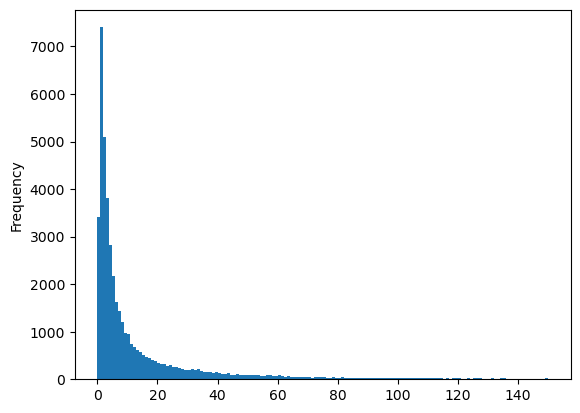

In [15]:
MB_beers['nbr_matched_valid_ratings.1'].sort_values().plot(kind='hist', range = (0, 150), bins= 150)

In [14]:
MB_beers['nbr_matched_valid_ratings.1'].describe()

count    45640.000000
mean        22.361941
std         80.101475
min          0.000000
25%          2.000000
50%          5.000000
75%         16.000000
max       5270.000000
Name: nbr_matched_valid_ratings.1, dtype: float64

In [18]:
filt_MB_beers = MB_beers[MB_beers['nbr_matched_valid_ratings.1'] >= 5].copy(deep=True) 
print(filt_MB_beers.shape)

(23112, 33)


Fig. 6 in the previously mentioned paper, shows that the herding effect, although never converging to 0, becomes stable with a larger number of ratings with respect to the first one. Thus, we will keep the beers with at least 5 ratings. Note that 5 is the median value of the number of ratings. However, discarding these samples still leaves us with a large amount of data (23112 beers).
Then, we will partition the data into 3, trying to make groups with a similar amount of data. Thus, refering to the new tertiales.

In [20]:
filt_MB_beers['nbr_matched_valid_ratings.1'].quantile([0.33, 0.67])

0.33    10.0
0.67    27.0
Name: nbr_matched_valid_ratings.1, dtype: float64

In [21]:
L_filt_MB_beers = filt_MB_beers[filt_MB_beers['nbr_matched_valid_ratings.1'] <= 10].copy(deep=True) 
M_filt_MB_beers = filt_MB_beers[filt_MB_beers['nbr_matched_valid_ratings.1'] <= 27].copy(deep=True) 
H_filt_MB_beers = filt_MB_beers[filt_MB_beers['nbr_matched_valid_ratings.1'] > 27].copy(deep=True) 

Now, we will do a scatter plot for each beer (in different colors) to see the trend in the herding effect. We will quantize the effect as the relation with respect to the average of the previous ratings. Note that this graph will be measured up until the minimum number of ratings used to determine the partition in the previous step (since this is the assured number of ratings that all the beers in the group will have).

In [22]:
display(L_filt_MB_beers)

,abv,avg,avg_computed,avg_matched_valid_ratings,ba_score,beer_id,beer_name,beer_wout_brewery_name,brewery_id,brewery_name,...,brewery_id.1,brewery_name.1,nbr_matched_valid_ratings.1,nbr_ratings.1,overall_score,style.1,style_score,zscore.1,diff,sim
6,4.6,NaN,NaN,NaN,NaN,169948,Bally Black Stout,Bally Black Stout,40309,Ards Brewing Company,...,13538,Ards Brewing Co.,6,6,NaN,Stout,NaN,0.823699,1.000000,1.0
11,8.0,4.28,4.280000,4.280000,NaN,224564,El Capitan,El Capitan,45082,Bullhouse Brewing Company,...,27006,Bullhouse Brewing Company,6,6,NaN,Imperial Stout,NaN,-0.215108,1.000000,1.0
14,4.5,4.08,4.140000,4.060000,NaN,196861,Rowlock,Rowlock,35512,Clearsky Brewing Co.,...,18096,Clearsky,7,7,NaN,Golden Ale/Blond Ale,NaN,-1.149657,1.000000,1.0
15,10.8,4.03,4.030000,NaN,NaN,268387,Baltic Porter 2016,Baltic 2016 Porter,36583,Farmageddon Brewing Co-op,...,19507,Farmageddon Brewing Co-Op,9,9,NaN,Baltic Porter,NaN,0.429358,0.707442,1.0
23,6.4,3.63,3.630000,NaN,NaN,283425,Vermont Pale Ale,Pale Vermont Ale,36583,Farmageddon Brewing Co-op,...,19507,Farmageddon Brewing Co-Op,5,5,NaN,American Pale Ale,NaN,-0.023696,0.408836,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45626,9.0,4.04,4.012353,4.052500,86.0,93947,St. Whatshername,Whatshername St,29624,Pour Decisions Brewing Company,...,13007,Pour Decisions Brewing Company,7,7,NaN,Abbey Tripel,NaN,0.512827,0.415215,1.0
45627,4.2,3.75,3.750000,NaN,NaN,107819,The Actress And The Bishop,The Actress And Bishop,29624,Pour Decisions Brewing Company,...,13007,Pour Decisions Brewing Company,10,10,48.0,Golden Ale/Blond Ale,76.0,-0.245011,0.803415,1.0
45629,3.9,3.58,3.583333,3.583333,NaN,16601,Amarillo Light Pilsner,Amarillo Light Pilsner,7979,Hoppers Grille And Brewery,...,1407,Hoppers Grille & Brewery,7,7,NaN,Pilsener,NaN,-1.637740,0.706047,1.0
45631,5.0,3.92,3.916667,3.916667,NaN,16603,Royal Bohemian Pilsner,Bohemian Royal Pilsner,7979,Hoppers Grille And Brewery,...,1407,Hoppers Grille & Brewery,9,9,NaN,Czech Pilsner (Světlý),NaN,-0.256732,0.632922,1.0


In [23]:
display(MB_ratings)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,brewery_name.1,date.1,overall.1,palate.1,rating.1,style.1,taste.1,text.1,user_id.1,user_name.1
0,11.3,4.50,4.50,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.50,...,Brasserie Rochefort,1387710000,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...,83106,Erzengel
1,5.0,NaN,NaN,28191,Myanmar Lager Beer,9369,Myanmar Brewery and Distillery,1322650800,NaN,NaN,...,Myanmar Brewery and Distillery,1322564400,6.0,2.0,1.7,Pale Lager,4.0,"Can. Weak and watery, not the best beer of the...",91324,visionthing
2,5.0,3.50,3.50,57911,Cantillon Tyrnilambic Baie D’Argousier Lambic,388,Brasserie Cantillon,1344074400,4.0,4.00,...,Cantillon,1353582000,17.0,4.0,4.1,Lambic Style - Fruit,8.0,"Bottle @ One Pint Pub, Helsinki. Originally ra...",98624,tiong
3,5.0,4.00,3.50,57913,Cantillon Pikkulinnun Viskilambic,388,Brasserie Cantillon,1344074400,4.0,4.00,...,Cantillon,1416222000,16.0,4.0,4.1,Lambic Style - Unblended,9.0,"Draught @Â Pikkulintu, Helsinki, Finland. A pr...",98624,tiong
4,6.0,4.00,4.00,81125,Drie Fonteinen Oude Geuze - Armand & Tommy,2216,Brouwerij 3 Fonteinen,1346234400,4.0,4.00,...,Brouwerij 3 Fonteinen,1345284000,16.0,4.0,4.0,Lambic Style - Gueuze,8.0,750ml bottleBottling date: 2011/02/17 - Pours ...,98624,tiong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21959,8.5,4.50,3.50,28030,Valeir Divers,3463,Brouwerij Contreras,1323946800,4.0,4.00,...,Contreras,1323946800,15.0,4.0,3.7,Abbey Tripel,7.0,Valeir Divers 33cl bottle from www.belgianbeer...,137922,TheBeerWatcher
21960,8.0,4.25,4.25,5057,Fantôme Saison,738,Brasserie Fantôme,1484046000,4.0,4.00,...,Brasserie Fantôme,1487502000,16.0,4.0,4.0,Saison,8.0,.................................................,394232,jonj
21961,5.2,NaN,NaN,349,Jupiler,134,Brasserie Piedboeuf,1393239600,NaN,NaN,...,Brasserie Piedboeuf (InBev),1393153200,1.0,1.0,1.2,Pale Lager,2.0,"Biere, foin, pain grillÃ©, terreux, banane, ca...",304802,maxilouis
21962,6.5,3.00,3.00,127162,Redenaar,32560,Brouwerij d'Oude Maalderij,1419764400,3.0,2.75,...,dOude Maalderij,1397037600,17.0,3.0,3.9,Belgian Ale,8.0,This is the first blond ale from this brewery....,276666,simoen


In [ ]:
list_beers = 